In [341]:
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from collections import defaultdict

In [342]:
from typing import Any

In [343]:
SEED = 42
random.seed(SEED)

In [344]:

def df_metrics(**kwargs):
    return pd.DataFrame(kwargs, index = [0])

Read data
junction_aa - RBD sequence data
Antibody - type of antibody target to RBD
Label - 1 bind, 0 not-bind

In [353]:
whole_train = pd.read_csv('../dataset/whole_train.csv')

In [354]:
whole_test = pd.read_csv('../dataset/whole_test.csv')

In [355]:
LY16_train = whole_train.loc[whole_train['Antibody']=='LY16']
LY16_train

,junction_aa,consensus_count,Label,Distance,Antibody
406886,KNEGFNCYIPLVTYGFHTTTGVSY,1,0,7,LY16
406887,KNKGFNCYSPITEYGFFPTNGKNF,2,1,9,LY16
406888,SKQGFNCYCPLIGYGFQRTFGVGW,1,0,9,LY16
406889,KNRQFNCYWPLVRYGFWTTSGVGW,1,0,9,LY16
406890,KNPGFNCYLPLGHYGFQPTNGRDF,3,1,7,LY16
...,...,...,...,...,...
433762,KNKGFNCYFPIVNYGFWTTNGRGY,1,0,7,LY16
433763,KNKGFNCYSPLRGYGFFTTTGVDY,1,0,8,LY16
433764,KNKGFNCYPPIGTYGFHRTTGVDW,1,0,10,LY16
433765,KNPGFNCYSPLATYGFFTTTGGDF,1,1,10,LY16


In [356]:
LY16_test = whole_test.loc[whole_test['Antibody']=='LY16']
LY16_test

,junction_aa,consensus_count,Label,Distance,Antibody
45210,KNTGFNCYFPLLAYGFHPTSGVDY,1,0,6,LY16
45211,KNPGFNCYHPIVGYGFQPTIGHDF,1,1,9,LY16
45212,TTAGFNCYMPITRYGFWPTDGRSW,1,0,12,LY16
45213,RNRGFNCYDPIHKYGFHRTNGLNY,1,1,10,LY16
45214,KNKKFNCYVPLVTYGFHPTNGVNY,1,0,7,LY16
...,...,...,...,...,...
48192,KNQGFNCYAPLVAYGFHPTAGRGF,1,1,8,LY16
48193,KNGGFNCYVPLGRYGFFRTNGRGY,1,1,7,LY16
48194,KNTQFNCYRPLASYGFWRTGGIDF,1,1,10,LY16
48195,KNEGFNCYTPLANYGFYTTVGRSW,1,1,9,LY16


One-hot encoding sequence

In [357]:
def encode_seq(sequence: str) -> np.ndarray:
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

Process dataframe to get one-hot encoded sequence and labels.

In [358]:
def process_df(df: pd.DataFrame, col_seq: str) -> tuple[Any, Any]:
    features = df.loc[:, col_seq].apply(lambda x: encode_seq(x)).to_numpy()
    X_features = []
    for arr in features:
        X_features.append(list(arr.reshape(-1)))
    X_features = np.array(X_features)
    labels = df.loc[:, "Label"].to_numpy()
    return X_features, labels


In [362]:
X_train, y_train = process_df(LY16_train, 'junction_aa')
X_test, y_test = process_df(LY16_test, 'junction_aa')

Calculation all regression metrics

In [360]:
def calculate_metrics(y_pred_cl: np.ndarray, y_pred_log: np.ndarray, y_true: np.ndarray):
    acc = metrics.accuracy_score(y_true, y_pred_cl)
    prec = metrics.precision_score(y_true, y_pred_cl)
    rec = metrics.recall_score(y_true, y_pred_cl)
    auc = metrics.roc_auc_score(y_true, y_pred_log)
    f1_ = metrics.f1_score(y_true, y_pred_cl)
    return acc, prec, rec, f1_, auc

In [366]:
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)

In [367]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [368]:
y_pred_cl = rf.predict(X_test)
y_pred_log = rf.predict_proba(X_test)[:, 1]

In [370]:
acc, prec, rec, f1_, auc = calculate_metrics(y_pred_cl, y_pred_log, y_test)

In [371]:
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.884165,0.880647,0.885424,0.883029,0.944885


Train catboost and find impontant positions in RBD sequence

In [305]:
model = CatBoostClassifier(random_seed=SEED, verbose = False)

In [372]:
model.fit(X_train, y_train)

In [373]:
y_pred_cl = model.predict(X_test)
y_pred_log = model.predict_proba(X_test)[:, 1]

In [374]:
acc, prec, rec, f1_, auc = calculate_metrics(y_pred_cl, y_pred_log, y_test)
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)

In [375]:
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.894208,0.882508,0.906441,0.894314,0.949006


In [378]:
def find_relevant_pos(model: object) -> list:
    feature_importance = model.feature_importances_
    st = 0
    chunks = []
    # split features of RBD sequence per position
    for i in range(20, len(feature_importance)+1, 20):
        chunks.append(feature_importance[st:i])
        st += 20
    # check if importance all aminoacid in current position equals to zero
    exclude_pos = []
    for i in range(len(chunks)):
        if all(chunks[i] == 0):
            exclude_pos.append(i)
    return exclude_pos



In [379]:
exclude_pos = find_relevant_pos(model)
exclude_pos

[4, 5, 6, 7, 9, 13, 14, 15, 18, 20]

Exclude position in sequences

In [383]:
def process_seq(seq: str) -> str:
    reduce_seq = ''.join([seq[i] for i in range(len(seq)) if i not in exclude_pos])
    return reduce_seq

In [384]:
LY16_train['reduce_seq'] = LY16_train['junction_aa'].apply(lambda x: process_seq(x))

/tmp/ipykernel_15245/2331829134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LY16_train['reduce_seq'] = LY16_train['junction_aa'].apply(lambda x: process_seq(x))


In [385]:
LY16_test['reduce_seq'] = LY16_test['junction_aa'].apply(lambda x: process_seq(x))

/tmp/ipykernel_15245/515855292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LY16_test['reduce_seq'] = LY16_test['junction_aa'].apply(lambda x: process_seq(x))


In [386]:
LY16_test

,junction_aa,consensus_count,Label,Distance,Antibody,reduce_seq
45210,KNTGFNCYFPLLAYGFHPTSGVDY,1,0,6,LY16,KNTGFLLAHPSVDY
45211,KNPGFNCYHPIVGYGFQPTIGHDF,1,1,9,LY16,KNPGHIVGQPIHDF
45212,TTAGFNCYMPITRYGFWPTDGRSW,1,0,12,LY16,TTAGMITRWPDRSW
45213,RNRGFNCYDPIHKYGFHRTNGLNY,1,1,10,LY16,RNRGDIHKHRNLNY
45214,KNKKFNCYVPLVTYGFHPTNGVNY,1,0,7,LY16,KNKKVLVTHPNVNY
...,...,...,...,...,...,...
48192,KNQGFNCYAPLVAYGFHPTAGRGF,1,1,8,LY16,KNQGALVAHPARGF
48193,KNGGFNCYVPLGRYGFFRTNGRGY,1,1,7,LY16,KNGGVLGRFRNRGY
48194,KNTQFNCYRPLASYGFWRTGGIDF,1,1,10,LY16,KNTQRLASWRGIDF
48195,KNEGFNCYTPLANYGFYTTVGRSW,1,1,9,LY16,KNEGTLANYTVRSW


In [387]:
X_train, y_train = process_df(LY16_train, 'reduce_seq')

In [388]:
model = CatBoostClassifier(random_seed=SEED, verbose = False)

In [389]:
model.fit(X_train, y_train)

In [390]:
X_test, y_test = process_df(LY16_test, 'reduce_seq')

In [391]:
y_pred_cl = model.predict(X_test)
y_pred_log = model.predict_proba(X_test)[:, 1]

In [392]:
acc, prec, rec, f1_, auc = calculate_metrics(y_pred_cl, y_pred_log, y_test)
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)

In [393]:
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.894208,0.882508,0.906441,0.894314,0.949006


As we can see metrics are the same, positions in exclude_pos are not important for the classification task

Let's visualize distribution of aminoacid per position between bind and not-bind RBD variants

In [394]:
non_bind_Ly16 = LY16_train[LY16_train.Label==0]
bind_Ly16 = LY16_train[LY16_train.Label==1]

In [395]:
seq_zeros_Ly16 = np.array(non_bind_Ly16['junction_aa'].tolist())
seq_ones_Ly16 = np.array(bind_Ly16['junction_aa'].tolist())

In [396]:
def def_value():
    return 0

In [397]:
def calculate_distr_aa(sequences: list):
    distr_aa = defaultdict(list)
    for seq in sequences:
        for i in range(len(seq)):
            distr_aa[i].append(seq[i])
            
    freq_per_pos = defaultdict(dict)
    for pos in distr_aa:
        aa, counts = np.unique(distr_aa[pos], return_counts=True)
        count = dict(zip(aa, counts))
        freq_per_pos[pos] = defaultdict(def_value, count)
    return freq_per_pos
        
        
    

In [398]:
freq_zeros_Ly16 = calculate_distr_aa(seq_zeros_Ly16)
freq_ones_Ly16 = calculate_distr_aa(seq_ones_Ly16)


In [402]:
def plot_distr(pos, freq_ones, freq_zeros, name):
    X = set(freq_ones[pos].keys()).intersection(set(freq_zeros[pos].keys()))
    bind = [freq_ones[pos][aa] for aa in X]
    non_bind = [freq_zeros[pos][aa] for aa in X]
    X_axis = np.arange(len(X))
    plt.bar(X_axis - 0.2, bind, 0.4, label = 'binding')
    plt.bar(X_axis + 0.2, non_bind, 0.4, label = 'non-binding')
    plt.xticks(X_axis, X)
    plt.xlabel("Aminoacid")
    plt.ylabel("Frequency")
    plt.title(f"Frequency aminoacids in {pos} position of {name} variant")
    plt.legend()
    plt.show()

Plot frequency distribution of aminoacid per position between bind and not-bind RBD variants

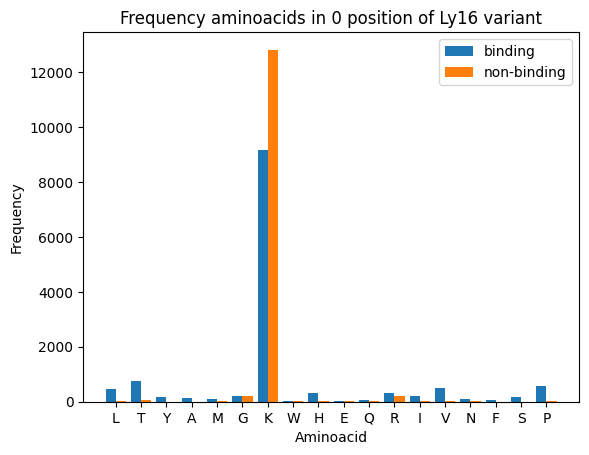

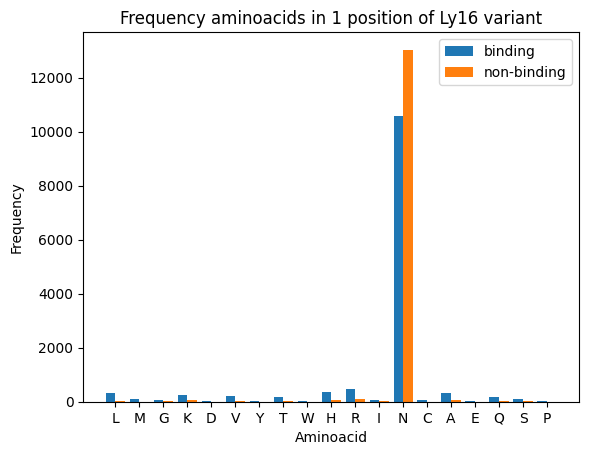

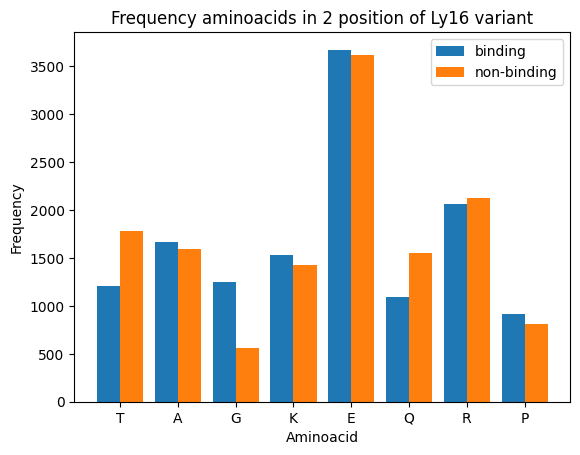

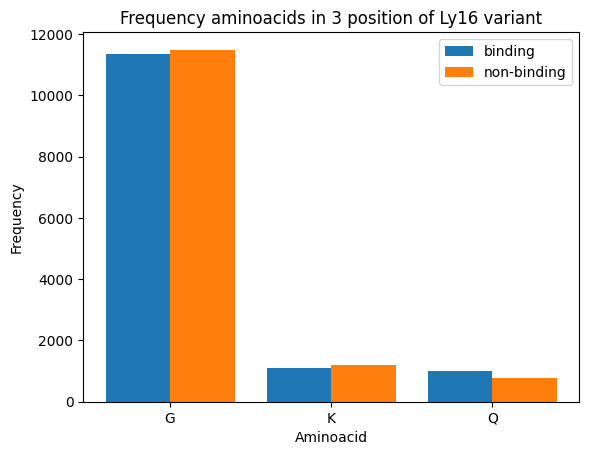

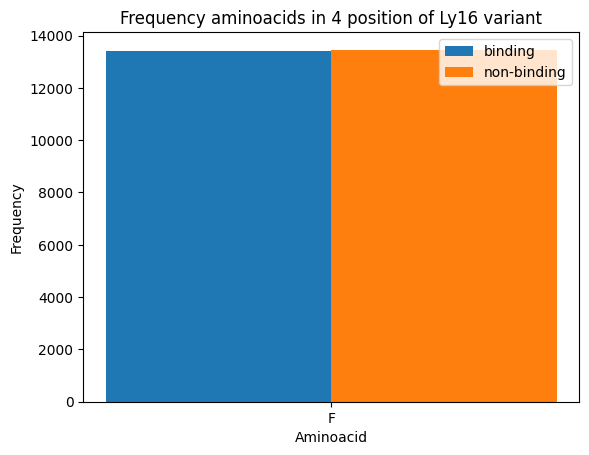

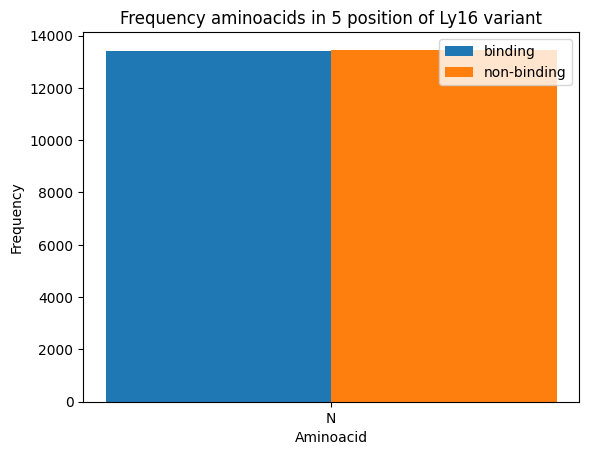

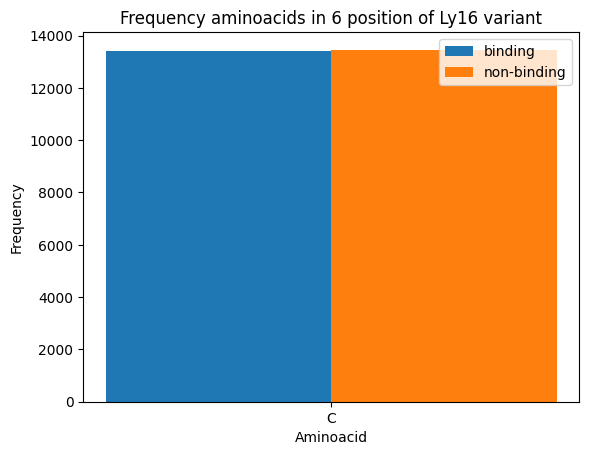

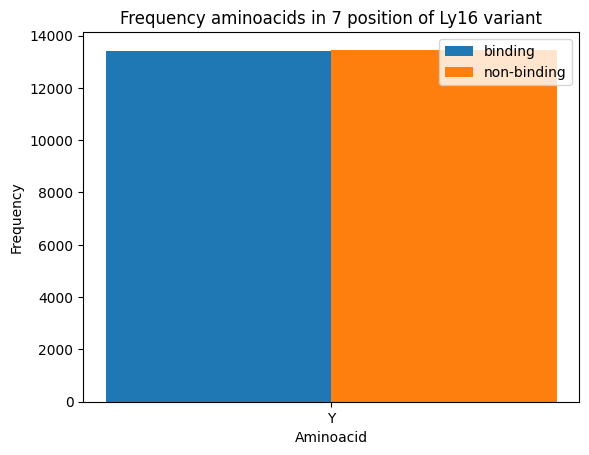

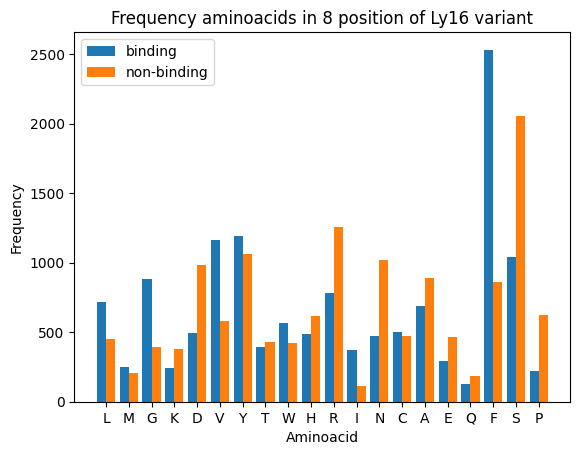

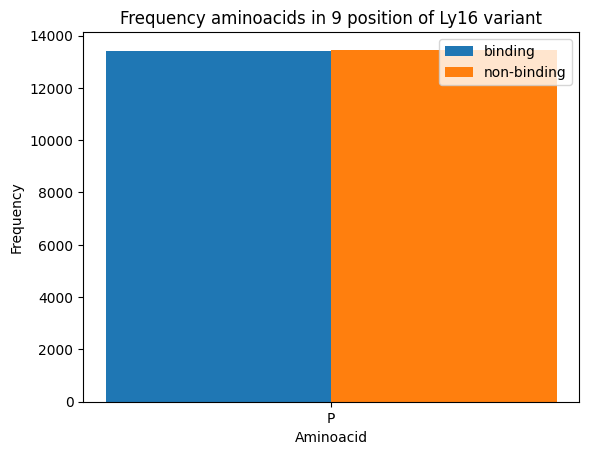

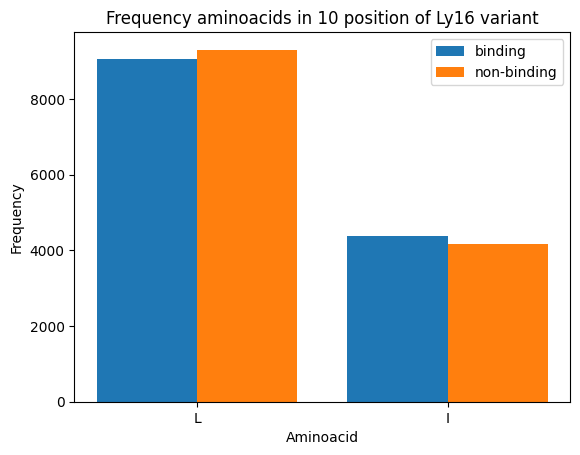

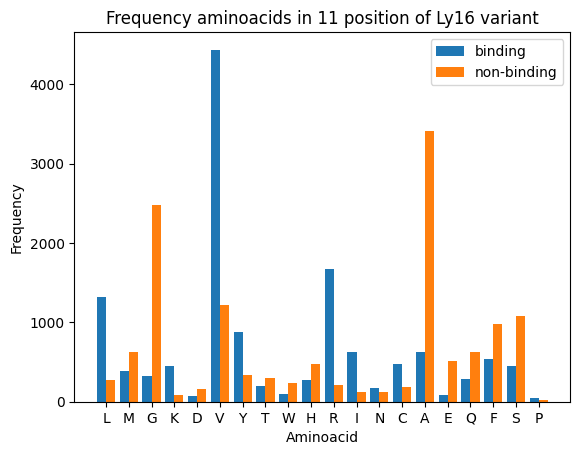

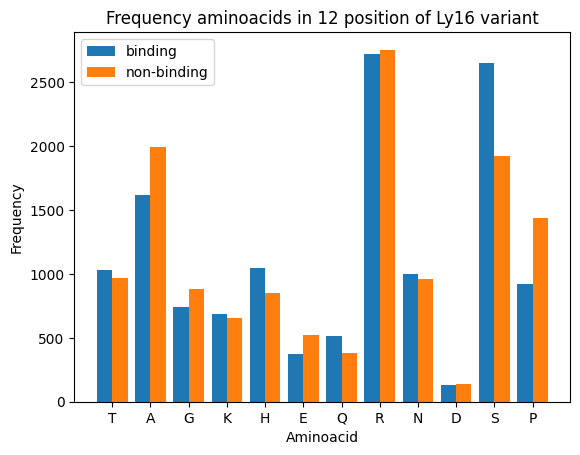

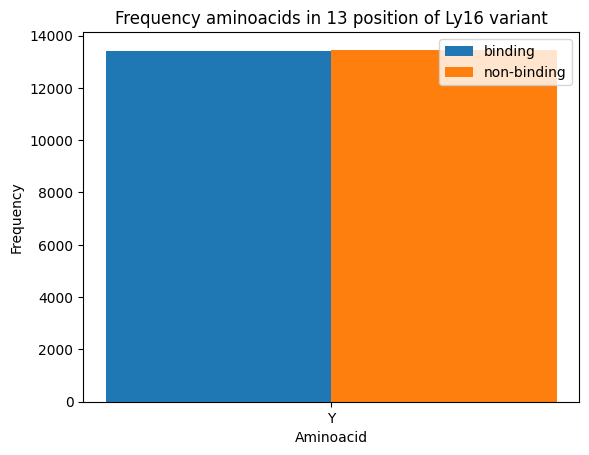

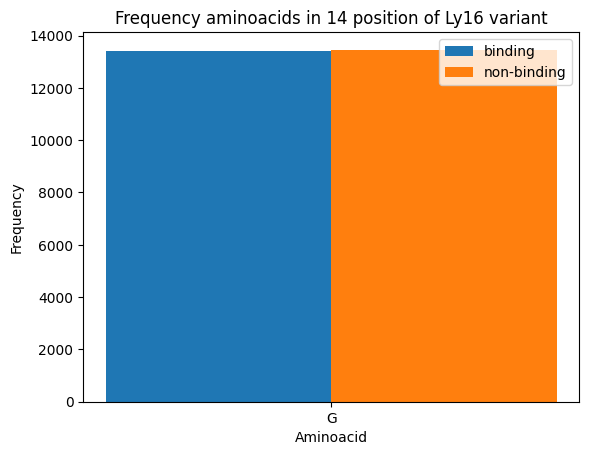

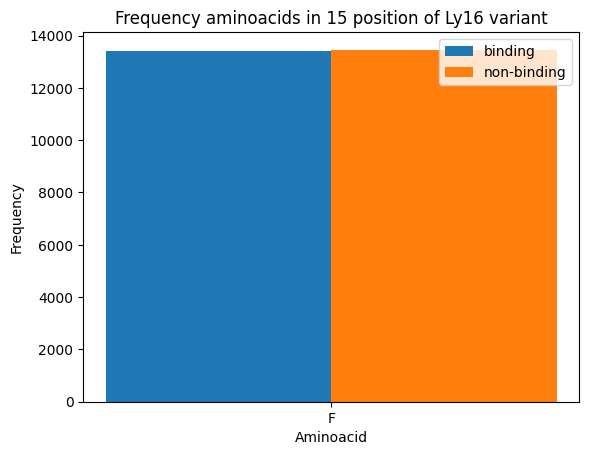

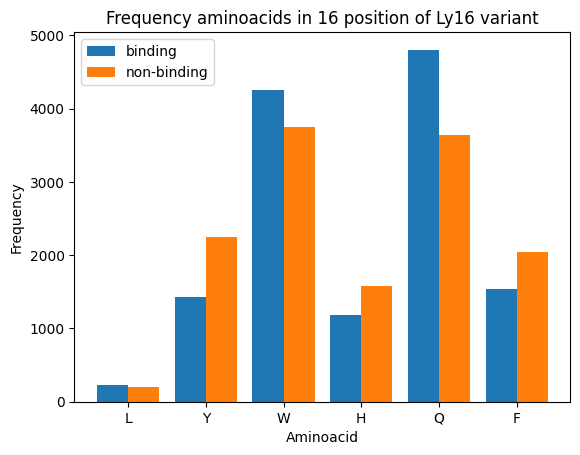

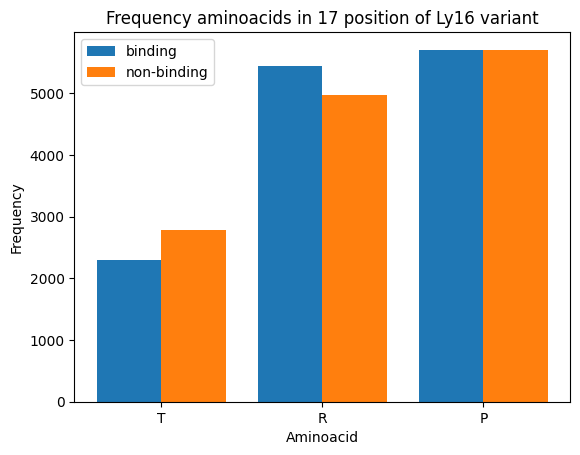

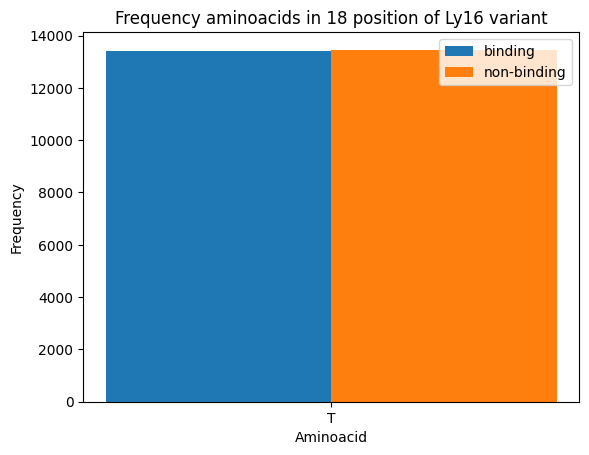

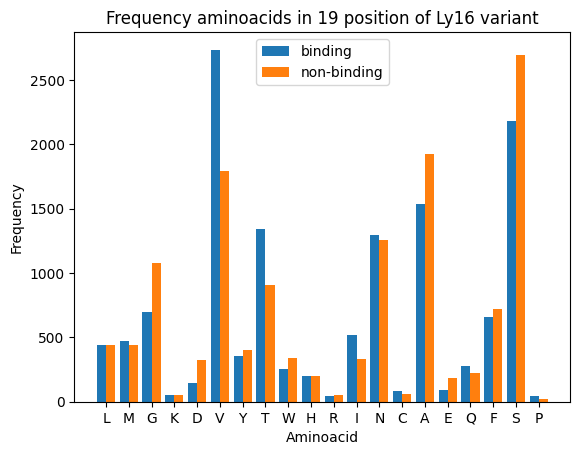

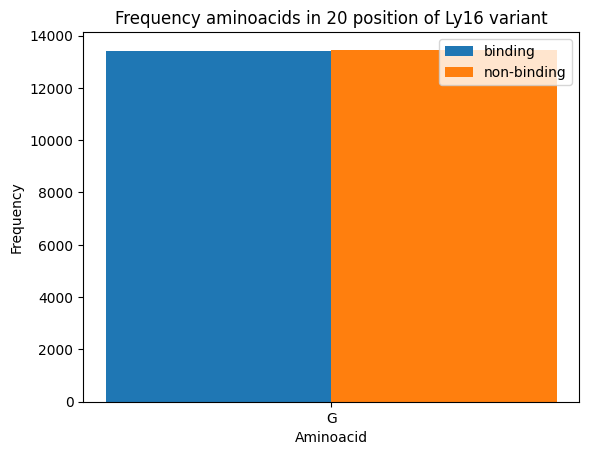

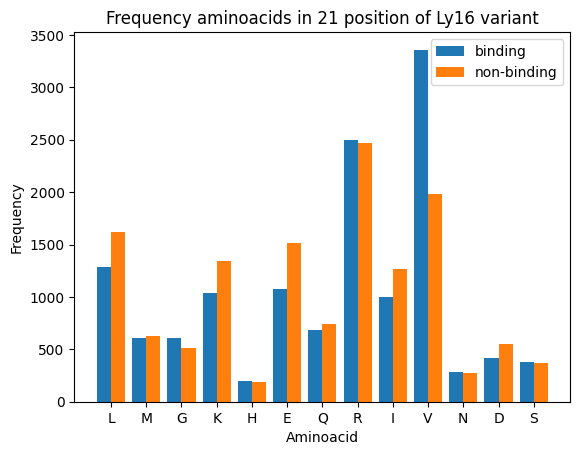

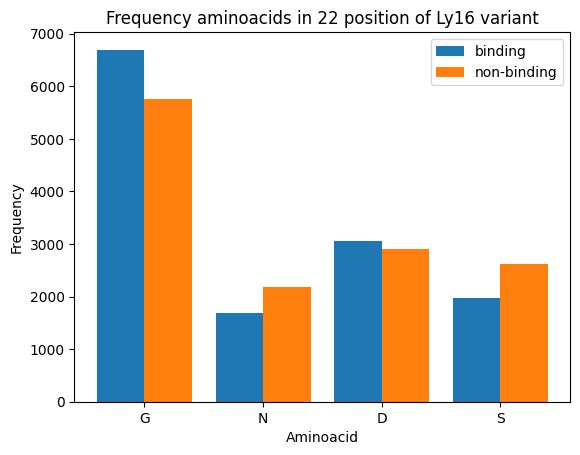

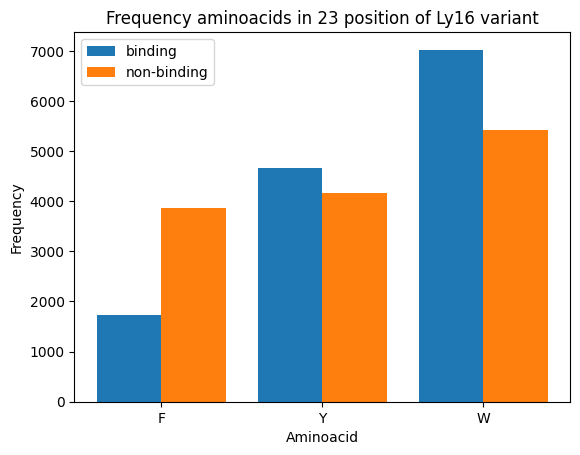

In [403]:
for pos in range(24):
    plot_distr(pos, freq_zeros_Ly16, freq_ones_Ly16, 'Ly16')


In [401]:
exclude_pos

[4, 5, 6, 7, 9, 13, 14, 15, 18, 20]

As we can see RBD sequence in positions (exclude_pos) have only one constant aminoacid